## Step 1. Import all necessary stuff

In [ ]:
import os
import sys
from PIL import Image

from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90, ElasticTransform,
    Transpose, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, Cutout, RandomFog,
    RandomRain, RandomSunFlare, VerticalFlip, Downscale, RandomShadow, CLAHE, RGBShift,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, ToFloat, MultiplicativeNoise, JpegCompression
)
import cv2
import numpy as np
import tensorflow as tf
tf.enable_eager_execution()

from tensorflow.python.data.experimental import AUTOTUNE
from tensorflow.keras.backend import ctc_decode
from tensorflow.keras import backend as K
from tqdm.notebook import tqdm
import joblib
import matplotlib.pyplot as plt
from crnn import get_model
from IPython.display import clear_output

## Step 2. Create augmentor

In [1]:
def strong_aug(p=0.5):
    '''Constructs augmentor for images with given probability p.

        Args:
            p (float): probability in [0, 1), that image will be augmented.
                Higher values corresponds to heavier augmentations.

        Returns:
            albumentations.augmentations.Compose.

    '''
    return Compose([
        # add one of basic image quality reduction augmentations
        OneOf([
            OneOf([
                MotionBlur(blur_limit=(3, 3), p=0.1),
                MedianBlur(blur_limit=(3, 3), p=0.1),
                Blur(blur_limit=(3, 3), p=0.15),
                JpegCompression(quality_lower=30, quality_upper=80, p=0.1),
                Downscale(p=0.2, scale_min=0.5, scale_max=0.75),
            ], p=0.2),
            
        ], p=0.1),
        # add color augmentation
        RGBShift(r_shift_limit=(0, 0.2), g_shift_limit=(0, 0.2), b_shift_limit=(0, 0.2), p=0.4),
        # add one of basic image noise applying augmentations
        OneOf([
            GaussNoise(p=0.2, var_limit=(0.0001, 0.001)),
            IAASharpen(p=0.2),
            IAAEmboss(p=0.1),
        ], p=0.4),
        # add scale augmentation
        ShiftScaleRotate(rotate_limit=5, shift_limit=0.0525, scale_limit=(-0.15, 0.3), p=0.4),
        # add distortion and perspective augmentations
        OneOf([
           OpticalDistortion(p=0.5),
           GridDistortion(p=0.2),
        ], p=0.5),
    ], p=p)
augmentation = strong_aug(0.9)

def augment(x):
    '''Augments a bunch of images.

        Args:
            x (list or numpy.ndarray): list containing uint8 RGB images.

        Returns:
            numpy.ndarray contatining augmented images of dtype uint8.

    '''
    return np.uint8([augmentation(image=im)["image"] for im in x])

## Step 3. Construct teacher model if necessary

In [2]:
teacher = get_model(training=False, input_shape=(64, 128, 3), num_classes=23)
teacher.load_weights('captcha40k_crnn_best1.h5')

def predict(x):
    '''Average prediction on image with it's augmentations.

        Args:
            x (list or numpy.ndarray): list containing uint8 RGB images.

        Returns:
            numpy.ndarray contatining average predictions of dtype float32.

    '''
    x_pred = teacher.predict(np.concatenate([([im] + [augmentation(image=im)["image"] for _ in range(3)]) for im in x])/255.)
    return (.4*x_pred[::4]+.2*x_pred[1::4]+.2*x_pred[2::4]+.2*x_pred[3::4])

## Step 4. Define Captcha Dataset class

In [3]:
class DIV2K:
    '''Class implementing Captcha Dataset.
    To fasten learning process we can cache results in one file.
    This approach allows us to train on huge (millions) of examples, while
    still generating batches fast.

    '''
    def __init__(self,
                 subset='train',
                 images_dir='images',
                 caches_dir='caches'):
        '''Constructor of Captcha Dataset.
        Args:
            subset (str, default is 'train'): subset can be either train or valid.
            images_dir (str, default is 'images'): path to the folder with captcha images.
            caches_dir (str, default is 'caches'): path to the folder, where cache files
                would be located.

        '''
        if subset == 'train':
            self.image_ids = range(1, 801)
        elif subset == 'valid':
            self.image_ids = range(801, 901)
        else:
            raise ValueError("subset must be 'train' or 'valid'")

        self.subset = subset
        self.images_dir = images_dir
        self.caches_dir = caches_dir

        os.makedirs(images_dir, exist_ok=True)
        os.makedirs(caches_dir, exist_ok=True)

    def __len__(self):
        '''Returns length of dataset
        
        '''
        return len(self.image_ids)

    def dataset(self, batch_size=16, repeat_count=None, random_transform=True):
        '''Constructs Complete dataset with images, labels and preds with optional augmentation and shuffling.
                Args:
                    batch_size (int, default is 16): batch size of complete dataset.
                    repeat_count (int, default is None): defines how many times dataset will iterate until stopping.
                        None means infinite batch generation.
                    random_transform (bool, default is True): if True then apply augmentations to images.
                Returns:
                    tf.data.Dataset.

        '''
        ds = tf.data.Dataset.zip((self.hr_dataset(), self.preds_dataset(), self.labels_dataset()))
        ds = ds.shuffle(1024, seed=69)
        ds = ds.repeat(repeat_count)
        ds = ds.batch(batch_size)
        if random_transform:
            ds = ds.map(lambda img, pred, label: (tf.numpy_function(func=augment, inp=[img], Tout=tf.uint8),
                                                  pred,
                                                  label),
                        num_parallel_calls=AUTOTUNE)
        
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds

    def hr_dataset(self):
        '''Constructs images dataset with cached file.
                Args:
                    None
                Returns:
                    tf.data.Dataset.

        '''
        # use images dataset as input
        ds = self._images_dataset(self._hr_image_files()).cache(self._hr_cache_file())

        if not os.path.exists(self._hr_cache_index()):
            self._populate_cache(ds, self._hr_cache_file())

        return ds
    
    def preds_dataset(self, batchsize=1024):
        '''Constructs teacher predictions dataset with cached file.
                Args:
                    batchsize (int, default is 1024): batch size which will speed up
                        dataset construction.
                Returns:
                    tf.data.Dataset.

        '''
        # use images dataset as input
        ds = self.hr_dataset()

        if not os.path.exists(self._hr_cache_index()):
            self._populate_cache(ds, self._hr_cache_file())

        ds = ds.batch(batchsize)
        ds = ds.map(lambda x: tf.numpy_function(func=predict, inp=[x], Tout=tf.float32))
        ds = ds.unbatch()
        ds = ds.cache(self._preds_cache_file())
        
        if not os.path.exists(self._preds_cache_index()):
            self._populate_cache(ds, self._preds_cache_file())

        return ds
    
    def labels_dataset(self, batchsize=1024):
        '''Constructs Labels dataset with cached file.
                Args:
                    batchsize (int, default is 1024): batch size which will speed up
                        dataset construction.
                Returns:
                    tf.data.Dataset.

        '''
        # use teacher preds to extract "true" labels
        ds = self.preds_dataset()
        ds = ds.batch(batchsize)
        
        ds = ds.map(lambda x: tf.nn.relu(ctc_decode(x[:, 2:], tf.ones_like(x[:, 0, 0]) * 30, greedy=True)[0][0])[:, :5],
               num_parallel_calls=AUTOTUNE)
        # tricky way of aquiring length of labels
        ds = ds.map(lambda x: (tf.cast(x, tf.uint8), tf.reduce_sum(tf.cast(x > 0, tf.uint8), axis=-1)),
                    num_parallel_calls=AUTOTUNE)

        ds = ds.unbatch()
        ds = ds.cache(self._labels_cache_file())
        # creating cache file
        if not os.path.exists(self._labels_cache_index()):
            self._populate_cache(ds, self._labels_cache_file())

        return ds

    def _hr_cache_file(self):
        '''Defines images cache file depending on subset and returns it.

        '''
        return os.path.join(self.caches_dir, f'CAPTCHA_{self.subset}.cache')
    
    def _preds_cache_file(self):
        '''Defines teacher predictions cache file depending on subset and returns it.

        '''
        return os.path.join(self.caches_dir, f'PREDS_{self.subset}.cache')
    
    def _labels_cache_file(self):
        '''Defines labels cache file depending on subset and returns it.

        '''
        return os.path.join(self.caches_dir, f'LABELS_{self.subset}.cache')

    def _hr_cache_index(self):
        '''Defines images index file depending on cache file and returns it.

        '''
        return f'{self._hr_cache_file()}.index'
    
    def _preds_cache_index(self):
        '''Defines predictions index file depending on cache file and returns it.

        '''
        return os.path.join(self.caches_dir, f'{self._preds_cache_file()}.index')
    
    def _labels_cache_index(self):
        '''Defines labels index file depending on cache file and returns it.

        '''
        return os.path.join(self.caches_dir, f'{self._labels_cache_file()}.index')

    def _hr_image_files(self):
        '''Constructs list of images files located in images folder.

        '''
        images_dir = self._hr_images_dir()
        return [os.path.join(images_dir, image_id) for i, image_id in enumerate(os.listdir(images_dir))]

    def _hr_images_dir(self):
        '''Returns images folder.

        '''
        return self.images_dir

    @staticmethod
    def _images_dataset(image_files):
        '''Lazy reading and decoding a list of images.
                Args:
                    image_files (list): list containing paths to the images to decode.
                Returns:
                    tf.data.Dataset.

        '''
        ds = tf.data.Dataset.from_tensor_slices(image_files)
        ds = ds.map(tf.io.read_file)
        ds = ds.map(lambda x: tf.image.decode_png(x, channels=3), num_parallel_calls=AUTOTUNE)
        ds = ds.map(lambda x: tf.image.resize(x, [64,128], method='bilinear'), num_parallel_calls=AUTOTUNE)
        # by default tensorflow will decode images in unnormalized (max is 255) float32
        ds = ds.map(lambda x: tf.cast(x, tf.uint8), num_parallel_calls=AUTOTUNE)
        return ds

    @staticmethod
    def _populate_cache(ds, cache_file):
        '''Create a cache file by iteratevly going through all examples in dataset.
                Args:
                    ds (tensorflow.data.Dataset): Dataset, which will be cached.
                    cache_file (str): filepath to cache of the dataset.
                    
                Returns:
                    None.

        '''
        print(f'Caching decoded images in {cache_file} ...')
        pbar = tqdm()
        for _ in ds: pbar.update(1)
        print(f'Cached decoded images in {cache_file}.')

## Step 5. Construct train and test Datasets

In [11]:
div2k_train = DIV2K(subset='train',
                     images_dir='captcha/screens/recognized',
                     caches_dir='captcha/caches')
ds = div2k_train.dataset(batch_size=128, random_transform=True)

In [6]:
div2k_test = DIV2K(subset='valid',
                     images_dir='captcha/screens/recognized',
                     caches_dir='captcha/caches_old')
ds_test = div2k_test.dataset(batch_size=256, random_transform=False, repeat_count=1)

### Sanity check if captcha is decoded correctly

In [33]:
for word in ctc_decode(next(iter(ds))[1][:, 2:], np.ones((64)) * 30, greedy=True)[0][0].numpy():
    result = ''
    for k in word:
        if k < 0: continue
        result += codemap[k]
    print(result)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
vemhs
qdc5
qz8x
d5m8h
v8sdk
z74sm
zmh7
zqszy
svupu
znuq7
syde
qdm8
quvzu
zham
smqx
zu7cq
sxzn
d5za
z2x55
h55kz
zdscv
smha
zee5z
vqha
hhnm
dsdz
vdycm
zyy5p
hazc7
znms5
h8pv
dqq7
hhks
zdzs7
zsk8
dx5nd
vnqe
hqv7
v7hp
susq
vsv2
ques
zh8e
qhkvd
zycz
svs75
dqhc
sczxx
vs8u
q5y7u
dmz4d
znvxk
scsv
v8nyq
h7mh
dhmz
vducv
dnpd
v22dq
qzpz
dvzcx
zvqx
zhedd
qxemh


## Step 6. Construct small student model

In [8]:
model = get_model(training=True, onnx=False, input_shape=(64, 128, 3), 
                  num_classes=23, small=True, teacher=True, alpha=0.7)
model.summary()
model.compile(loss={'loss': lambda y_true, y_pred: y_pred}, optimizer='adam')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          [(None, 64, 128, 3)] 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 64, 48)   1296        the_input[0][0]                  
__________________________________________________________________________________________________
maxpool1 (MaxPooling2D)         (None, 16, 32, 48)   0           conv1[0][0]                      
__________________________________________________________________________________________________
stage2/block1/1x1conv_1 (Conv2D (None, 16, 32, 20)   980         maxpool1[0][0]                   
______________________________________________________________________________________________

## Step 7. Define batch wrapper function

In [9]:
def get_batch(batch, teacher=None):
    '''Helper wrapper for batch preparation.
        Args:
            batch (list of Tensors): batch which you can get from tf.data.Dataset.
            teacher (int, default is None): If not None will add teacher's prediction
                field into batch dictionary.

        Returns:
            inputs (dict): input dict with named Tensors for the model.
            outputs (dict): output dict with named Tensors for the model.

    '''
    X_data = tf.cast(batch[0], tf.float32)/255.
    Y_data = batch[2][0]
    label_length = batch[2][1]
    batch_size = label_length.shape.as_list()[0]
    input_length = np.ones((batch_size, 1)) * 30
    

    inputs = {
        'the_input': X_data,  # (bs, 128, 64, 1)
        'the_labels': Y_data,  # (bs, 5)
        'input_length': input_length,  # (bs, 1) -> value = 30
        'label_length': label_length,  # (bs, 1) -> value = 5
    }

    if teacher is not None:
        inputs['teacher_preds'] = batch[1]
    
    outputs = {'loss' if teacher is not None else 'ctc': np.zeros((batch_size, 1))}
    return inputs, outputs

batch = next(iter(ds_test))
%timeit get_batch(batch, teacher=True)

2.5 ms ± 46 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Step 8. Training/Experiments

### Experiment 1: no Knowledge Distillation, trained on 850k filthy images for 70k steps

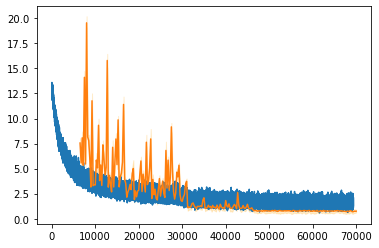

In [11]:
loss = []
loss_val = []
best_loss = 10
K.set_value(model.optimizer.lr, 2e-3)
pbar = tqdm()
start = 0#36000
i = start
eval_every = 250
for batch in ds:
    i += 1
    if i > 70_000:
        break
    if i % 1000 == 0:
        if i > 30000:
            K.set_value(model.optimizer.lr, 7.5e-4)
        if i > 50000:
            K.set_value(model.optimizer.lr, 1e-4)
        if i > 60000:
            K.set_value(model.optimizer.lr, 1e-5)

    loss.append(model.train_on_batch(*get_batch(batch=batch, teacher=None)))
    if i % eval_every == 0:
        tmp = []
        eval_indexes = frozenset(list(np.random.permutation(41_000//256)[:15]))
        for j, batch in enumerate(ds_test):
            if j in eval_indexes:
                tmp.append(model.evaluate(*get_batch(batch, train=False, teacher=None), verbose=False))
        tmp = np.array(tmp)
        loss_val.append((len(loss), np.percentile(tmp, 2.5), np.percentile(tmp, 97.5), tmp.mean()))

        our_metric = loss_val[-1][-1] + \
                     0.1*(loss_val[-1][-1]-loss_val[-1][1]) + \
                     0.5*(loss_val[-1][-2]-loss_val[-1][-1])

        if our_metric < best_loss:
            best_loss = our_metric
            model.save('captcha1M_crnn_best_conv1d_noKD{}.h5'.format(i%3))

        clear_output()
        pbar = tqdm(range(i+eval_every+1))
        pbar.update(i)
        shift = (i - start)//110
        shift_val = shift*10//eval_every
        plt.plot(loss[shift:])
        plt.plot(list(map(lambda x: x[0], loss_val[shift_val:])),
                 list(map(lambda x: x[-1], loss_val[shift_val:])))
        plt.fill_between(list(map(lambda x: x[0], loss_val[shift_val:])),
                         list(map(lambda x: x[1], loss_val[shift_val:])),
                         list(map(lambda x: x[2], loss_val[shift_val:])),
                         alpha=0.2, color='orange')
        plt.show()
    pbar.update(1)

### Experiment 2: 50% Knowledge Distillation, trained on 850k filthy images for 70k steps

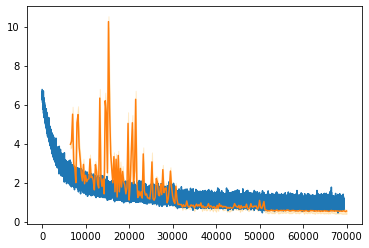

In [11]:
loss = []
loss_val = []
best_loss = 10
K.set_value(model.optimizer.lr, 2e-3)
pbar = tqdm()
start = 0#36000
i = start
eval_every = 250
for batch in ds:
    i += 1
    if i > 70_000:
        break
    if i % 1000 == 0:
        if i > 30000:
            K.set_value(model.optimizer.lr, 7.5e-4)
        if i > 50000:
            K.set_value(model.optimizer.lr, 1e-4)
        if i > 60000:
            K.set_value(model.optimizer.lr, 1e-5)

    loss.append(model.train_on_batch(*get_batch(batch=batch, teacher=True)))
    if i % eval_every == 0:
        tmp = []
        eval_indexes = frozenset(list(np.random.permutation(41_000//256)[:15]))
        for j, batch in enumerate(ds_test):
            if j in eval_indexes:
                tmp.append(model.evaluate(*get_batch(batch, train=False, teacher=True), verbose=False))
        tmp = np.array(tmp)
        loss_val.append((len(loss), np.percentile(tmp, 2.5), np.percentile(tmp, 97.5), tmp.mean()))

        our_metric = loss_val[-1][-1] + \
                     0.1*(loss_val[-1][-1]-loss_val[-1][1]) + \
                     0.5*(loss_val[-1][-2]-loss_val[-1][-1])

        if our_metric < best_loss:
            best_loss = our_metric
            model.save('captcha1M_crnn_best_conv1d_KD{}.h5'.format(i%3))

        clear_output()
        pbar = tqdm(range(i+eval_every+1))
        pbar.update(i)
        shift = (i - start)//110
        shift_val = shift*10//eval_every
        plt.plot(loss[shift:])
        plt.plot(list(map(lambda x: x[0], loss_val[shift_val:])),
                 list(map(lambda x: x[-1], loss_val[shift_val:])))
        plt.fill_between(list(map(lambda x: x[0], loss_val[shift_val:])),
                         list(map(lambda x: x[1], loss_val[shift_val:])),
                         list(map(lambda x: x[2], loss_val[shift_val:])),
                         alpha=0.2, color='orange')
        plt.show()
    pbar.update(1)

### Experiment 3: 50% Knowledge Distillation, trained on 1.5M filthy images for 70k steps

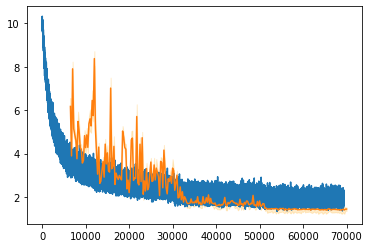

In [16]:
loss = []
loss_val = []
best_loss = 10
reverse_warmup = 1_000
K.set_value(model.optimizer.lr, 3e-3)
pbar = tqdm()
start = 0#36000
i = start
eval_every = 250
for batch in ds:
    i += 1
    if i <= reverse_warmup:
        K.set_value(model.optimizer.lr, 3e-3-1e-3*i/reverse_warmup)
    if i > 70_000:
        break
    if i % 1000 == 0:
        if i > 30000:
            K.set_value(model.optimizer.lr, 7.5e-4)
        if i > 50000:
            K.set_value(model.optimizer.lr, 1e-4)
        if i > 60000:
            K.set_value(model.optimizer.lr, 1e-5)

    loss.append(model.train_on_batch(*get_batch(batch=batch, teacher=True)))
    if i % eval_every == 0:
        tmp = []
        eval_indexes = frozenset(list(np.random.permutation(41_000//256)[:15]))
        for j, batch in enumerate(ds_test):
            if j in eval_indexes:
                tmp.append(model.evaluate(*get_batch(batch, train=False, teacher=True), verbose=False))
        tmp = np.array(tmp)
        loss_val.append((len(loss), np.percentile(tmp, 2.5), np.percentile(tmp, 97.5), tmp.mean()))

        our_metric = loss_val[-1][-1] + \
                     0.1*(loss_val[-1][-1]-loss_val[-1][1]) + \
                     0.5*(loss_val[-1][-2]-loss_val[-1][-1])

        if our_metric < best_loss:
            best_loss = our_metric
            model.save('captcha1500K_crnn_best_conv1d_KD{}.h5'.format(i%3))

        clear_output()
        pbar = tqdm(range(i+eval_every+1))
        pbar.update(i)
        shift = (i - start)//110
        shift_val = shift*10//eval_every
        plt.plot(loss[shift:])
        plt.plot(list(map(lambda x: x[0], loss_val[shift_val:])),
                 list(map(lambda x: x[-1], loss_val[shift_val:])))
        plt.fill_between(list(map(lambda x: x[0], loss_val[shift_val:])),
                         list(map(lambda x: x[1], loss_val[shift_val:])),
                         list(map(lambda x: x[2], loss_val[shift_val:])),
                         alpha=0.2, color='orange')
        plt.show()
    pbar.update(1)

### Experiment 4: 50% Knowledge Distillation, trained on 1.5M filthy images for 150k steps

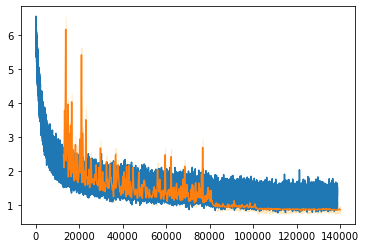

In [11]:
loss = []
loss_val = []
best_loss = 10
reverse_warmup = 250
K.set_value(model.optimizer.lr, 3e-3)
pbar = tqdm()
start = 0#36000
i = start
eval_every = 250
for batch in ds:
    i += 1
    if i <= reverse_warmup:
        K.set_value(model.optimizer.lr, 3e-3-1e-3*i/reverse_warmup)
    if i > 150_000:
        break
    if i % 1000 == 0:
        if i > 80_000:
            K.set_value(model.optimizer.lr, 7.5e-4)
        if i > 120_000:
            K.set_value(model.optimizer.lr, 1e-4)
        if i > 130_000:
            K.set_value(model.optimizer.lr, 1e-5)

    loss.append(model.train_on_batch(*get_batch(batch=batch, teacher=True)))
    if i % eval_every == 0:
        tmp = []
        eval_indexes = frozenset(list(np.random.permutation(41_000//256)[:15]))
        for j, batch in enumerate(ds_test):
            if j in eval_indexes:
                tmp.append(model.evaluate(*get_batch(batch, train=False, teacher=True), verbose=False))
        tmp = np.array(tmp)
        loss_val.append((len(loss), np.percentile(tmp, 2.5), np.percentile(tmp, 97.5), tmp.mean()))

        our_metric = loss_val[-1][-1] + \
                     0.1*(loss_val[-1][-1]-loss_val[-1][1]) + \
                     0.5*(loss_val[-1][-2]-loss_val[-1][-1])

        if our_metric < best_loss:
            best_loss = our_metric
            model.save('captcha1500K_crnn_best_conv1d_KD50_{}.h5'.format(i%3))

        clear_output()
        pbar = tqdm(range(i+eval_every+1))
        pbar.update(i)
        shift = (i - start)//110
        shift_val = shift*10//eval_every
        plt.plot(loss[shift:])
        plt.plot(list(map(lambda x: x[0], loss_val[shift_val:])),
                 list(map(lambda x: x[-1], loss_val[shift_val:])))
        plt.fill_between(list(map(lambda x: x[0], loss_val[shift_val:])),
                         list(map(lambda x: x[1], loss_val[shift_val:])),
                         list(map(lambda x: x[2], loss_val[shift_val:])),
                         alpha=0.2, color='orange')
        plt.show()
    pbar.update(1)

### Experiment 5: 30% Knowledge Distillation, trained on 1.5M filthy images for 280k steps, increased batch size after 120k steps

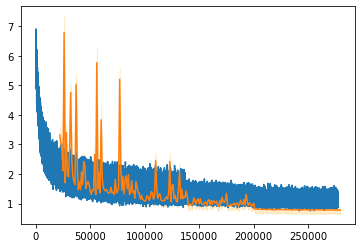

In [ ]:
loss = []
loss_val = []
best_loss = 10
reverse_warmup = 250
K.set_value(model.optimizer.lr, 2e-5)
pbar = tqdm()
start = 240_000#36000
i = start
eval_every = 1000
for batch in ds:
    i += 1
    
    if i <= reverse_warmup:
        K.set_value(model.optimizer.lr, 3e-3-1e-3*i/reverse_warmup)
    if i > 280_000:
        break
    if i % 1000 == 0:
        if i > 140_000:
            K.set_value(model.optimizer.lr, 2e-4)
        if i > 200_000:
            K.set_value(model.optimizer.lr, 2e-5)

    loss.append(model.train_on_batch(*get_batch(batch=batch, teacher=True)))
    if i % eval_every == 0:
        tmp = []
        eval_indexes = frozenset(list(np.random.permutation(41_000//256)[:15*eval_every//250]))
        for j, batch in enumerate(ds_test):
            if j in eval_indexes:
                tmp.append(model.evaluate(*get_batch(batch, train=False, teacher=True), verbose=False))
        tmp = np.array(tmp)
        loss_val.append((len(loss), np.percentile(tmp, 2.5), np.percentile(tmp, 97.5), tmp.mean()))

        our_metric = loss_val[-1][-1] + \
                     0.1*(loss_val[-1][-1]-loss_val[-1][1]) + \
                     0.5*(loss_val[-1][-2]-loss_val[-1][-1])

        if our_metric < best_loss:
            best_loss = our_metric
            model.save('captcha1500K_crnn_best_conv1d_KD30_{}.h5'.format(i%3))

        clear_output()
        pbar = tqdm(range(i+eval_every+1))
        pbar.update(i)
        shift = (i - start//5)//110
        shift_val = shift*10//eval_every
        plt.plot(loss[shift:])
        plt.plot(list(map(lambda x: x[0], loss_val[shift_val:])),
                 list(map(lambda x: x[-1], loss_val[shift_val:])))
        plt.fill_between(list(map(lambda x: x[0], loss_val[shift_val:])),
                         list(map(lambda x: x[1], loss_val[shift_val:])),
                         list(map(lambda x: x[2], loss_val[shift_val:])),
                         alpha=0.2, color='orange')
        plt.show()
    pbar.update(1)

## Step 9. Evaluation

### Load test images with true labels

In [15]:
alphabet = '24578acdehkmnpqsuvxyz'
alphamap = {k:i+1 for i,k in enumerate(alphabet)}
alphamap[' '] = 0
codemap = {v:k for k,v in alphamap.items()}
dataset = []
labels = []

for folder in [r'captcha\screens\recognized']:
    counter = -len(os.listdir(folder))
    for img_path in tqdm(list(filter(lambda x: int(x.split('_')[0]) > 1602932787, os.listdir(folder)))):
        dataset.append(np.uint8(Image.open(os.path.join(folder, img_path)).resize((128, 64), Image.QUAD)))
        labels.append(img_path.split('_')[-1].split('.')[0])
        counter += 1

### Construct model for evaluation, load weights

In [23]:
model = get_model(training=False, input_shape=(64, 128, 3), num_classes=23, small=True)
model.load_weights('captcha1500K_crnn_best_conv1d_KD50_0.h5')

### Predict labels with model

In [24]:
x_pred = model.predict(np.float32(np.concatenate([([im] + [augmentation(image=im)["image"] for _ in range(3)]) for im in dataset]))/255.,
                       verbose=True)

26972/26972 [==============================] - 12s 462us/sample


### Calculate accuracy - fraction of recognized captcha

In [34]:
# teacher.h5 -> 98.858, aug+ 99.021 | ~284 captchas/sec | 5_501_783 parameters

# captcha1500K_crnn_best_conv1d_KD30_3.h5 -> 91.221, aug+ 93.415 | ~2155 captchas/sec | 269_653 parameters
# captcha1500K_crnn_best_conv1d_KD30_0.h5 -> 91.146, aug+ 93.282
# captcha1500K_crnn_best_conv1d_KD30_1.h5 -> 90.894, aug+ 92.956
# captcha1500K_crnn_best_conv1d_KD30_2.h5 -> 86.089, aug+ 89.055
# captcha1500K_crnn_best_conv1d_KD50_0.h5 -> 86.742, aug+ 89.365
# captcha1500K_crnn_best_conv1d_KD50_1.h5 -> 86.652, aug+ 89.189

counter = 0
preds = []
for word in K.get_value(ctc_decode((1.0*x_pred[::4]+.0*x_pred[1::4]+.0*x_pred[2::4]+.0*x_pred[3::4])[:, 2:], 
                                input_length=np.ones((len(labels)))*30, greedy=True)[0][0]):
# for word in K.get_value(ctc_decode((0.35*x_pred[::4]+.216*x_pred[1::4]+.217*x_pred[2::4]+.217*x_pred[3::4])[:, 2:], 
#                                 input_length=np.ones((len(labels)))*30, greedy=True)[0][0]):
    result = ''
    for k in word:
        if k < 0: continue
        result += codemap[k]
    preds.append(result == labels[counter])
    counter+=1
np.mean(preds)

0.8674180631766276